In [ ]:
from IPython.display import Image, clear_output
!pip install roboflow
clear_output()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="lJpPmZag9RHtDPH9avGu", model_format="yolov5")
dataset = rf.workspace().project("bbp-ruwhz").version(2).download(location="/content/my_project")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/my_project in yolov5pytorch:: 100%|██████████| 212/212 [00:00<00:00, 2708.73it/s]


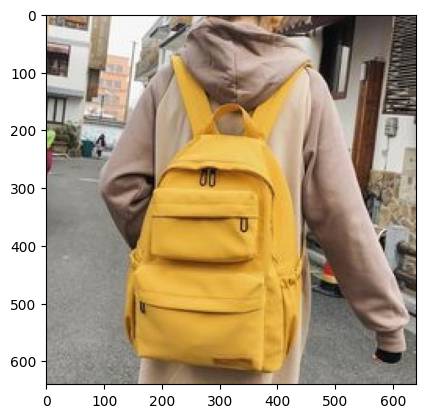

In [ ]:
plt.figure()
img = mpimg.imread('/content/my_project/train/images/02a48ac894ff090bcc47688b2ded534a_jpg.rf.e41830a90ce82a237f8a0612aca5fa15.jpg')
plt.imshow(img)
plt.show()

In [ ]:
img.shape

(640, 640, 3)

In [ ]:
import glob
image_paths=glob.glob('/content/my_project/train/images/*.jpg')

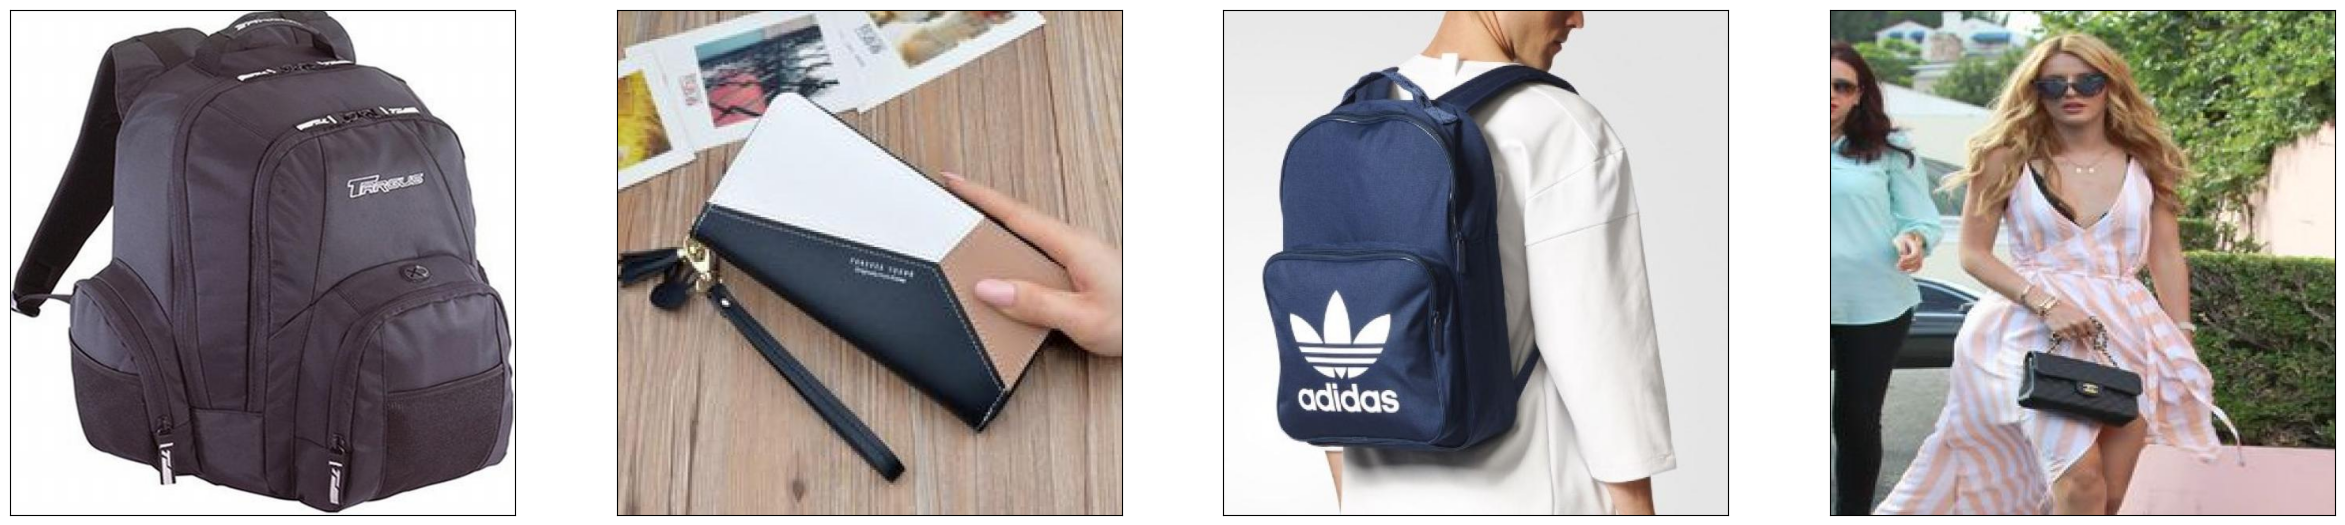

In [ ]:
plt.figure(figsize=(30,60))
for i,imgP in enumerate(image_paths[0:4]):
  ax = plt.subplot(1, 4, i + 1)
  img = mpimg.imread(imgP)
  plt.imshow(img)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

In [ ]:
import yaml
with open("/content/my_project/data.yaml", 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
num_classes

'3'

In [ ]:
# clone repositorio YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
#!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 15927, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 15927 (delta 20), reused 26 (delta 9), pack-reused 15880
Receiving objects: 100% (15927/15927), 14.60 MiB | 13.50 MiB/s, done.
Resolving deltas: 100% (10919/10919), done.
/content/yolov5


In [ ]:
!pip install -qr requirements.txt  # instalar dependencias (ignore los errores)
import torch

from IPython.display import Image, clear_output
#from utils.google_utils import gdrive_download

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 460 --batch 16 --epochs 100 --data /content/my_project/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/my_project/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=460, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2,

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

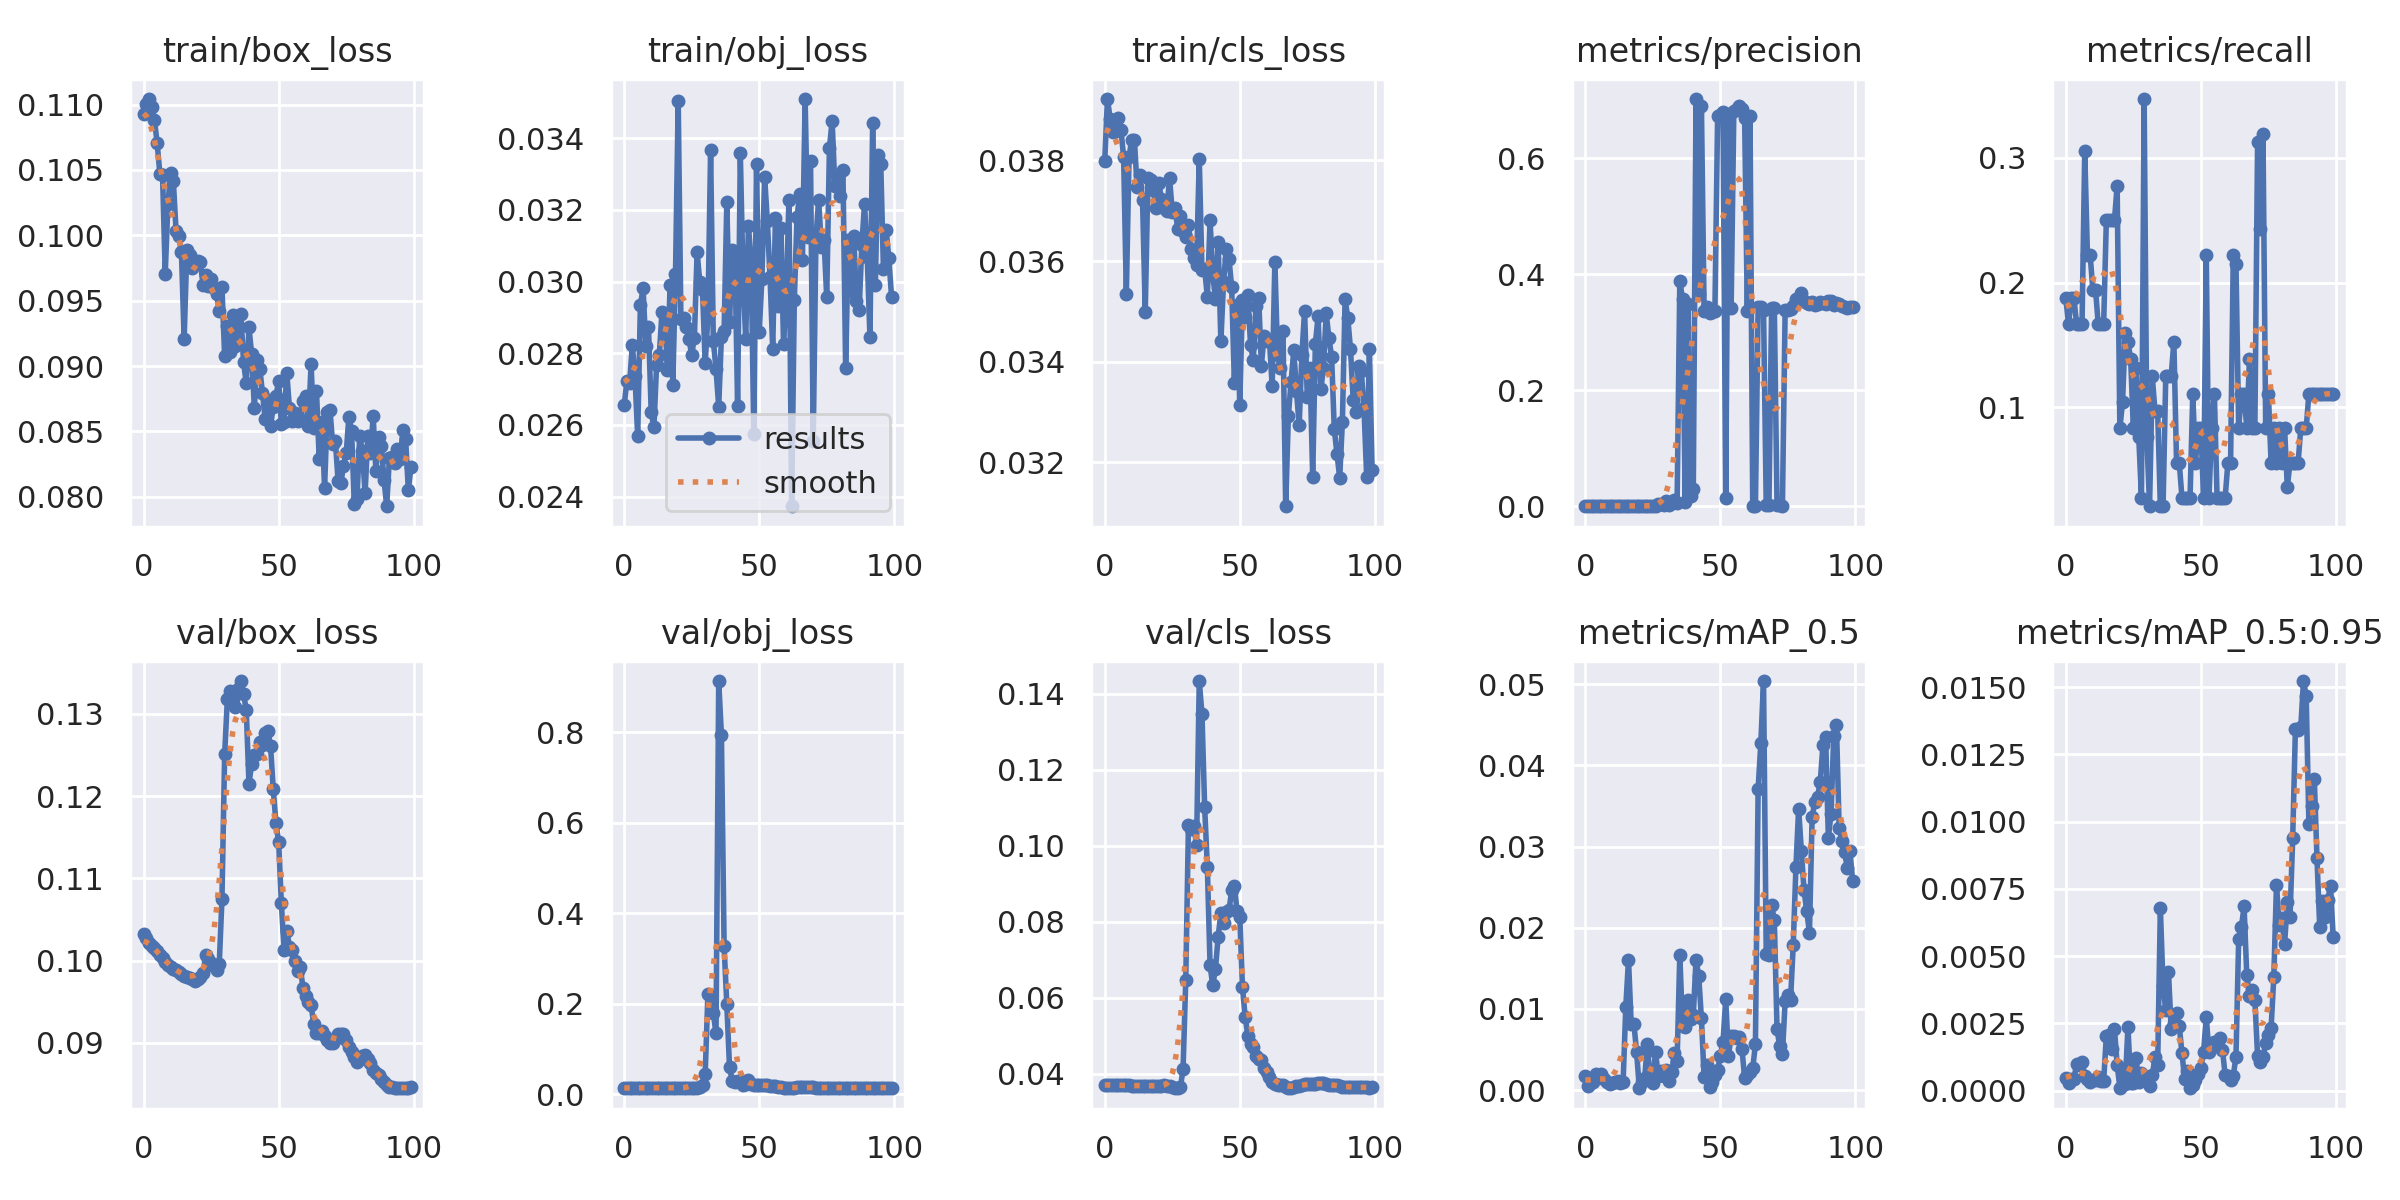

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

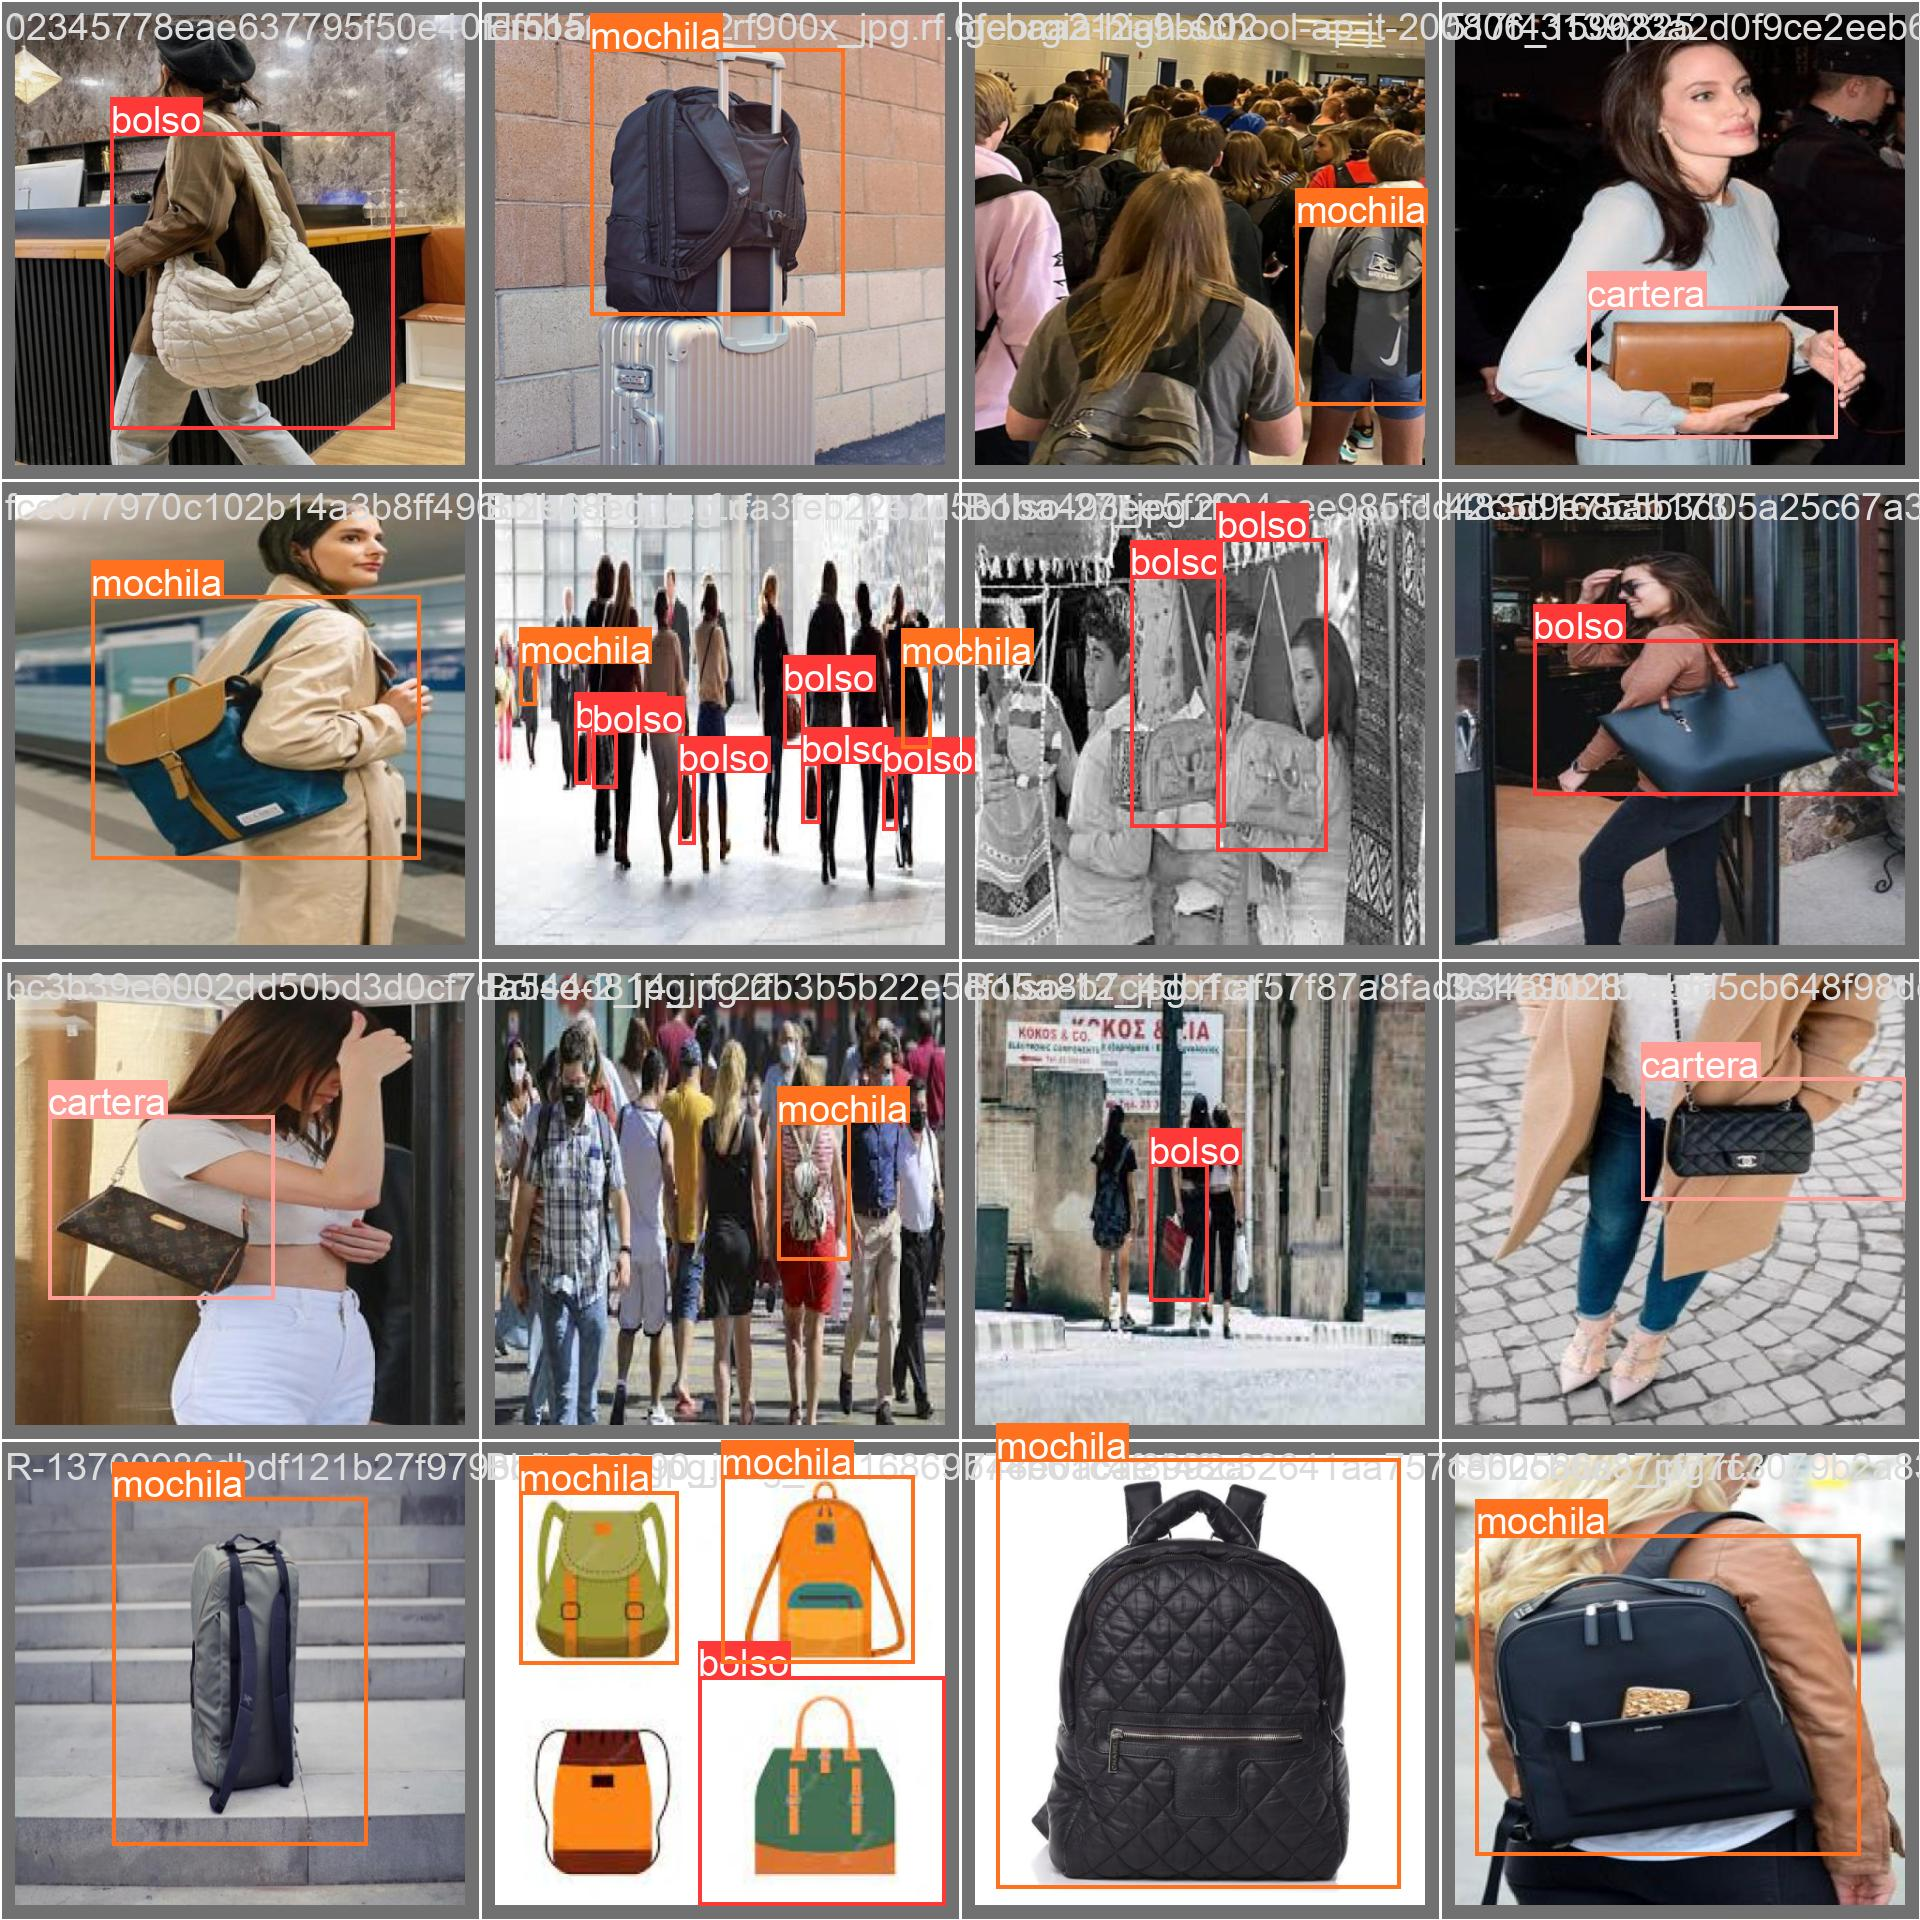

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=1000)

In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 460 --conf 0.01 --source /content/my_project/test/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=/content/my_project/test/images, data=data/coco128.yaml, imgsz=[460, 460], conf_thres=0.01, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-212-g9974d51 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
WARNING ⚠️ --img-size [460, 460] must be multiple of max stride 32, updating to [480, 480]
image 1/10 /content/my_project/test/images/-_jpg.rf.1136785c11a903e83af36e877f050004.jpg: 480x480 7 mochilas, 8.5ms
image 2/10 /content/my_project/test/images/11205522_fpx-tif_jpeg_jpg.rf.777733571b152be636805c307320b63

In [ ]:
import glob
from IPython.display import Image, display
for imageName in glob.glob('/content/yolov5/runs/detect/exp4/*.jpg'):
  display(Image(filename=imageName))
  print("\n")

In [ ]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/model